# Neural Style Transfer (Using VGG19 as base)

#### The following is an implementation of the paper on Neural Style Transfer by Leon A. Gatys. It shows style transfer between a style image and content image. The focus of this paper is on the Metrics used for calculating and extracting style error and content error. 
>As for the extracting style we have used certain intermediate layers from the pretrained VGG19 model for extracting style and certain layers for content.

Installing Required Libraries 

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import numpy as np

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [81]:
style_image_path = input("Enter the path of the style image: ")
content_image_path = input("Enter the path of the content image: ")

# print("Content Image Path:", content_image_path)
# print("Style Image Path:", style_image_path)

Enter the path of the style image: style_img.jpg
Enter the path of the content image: content_img.jpg


# Preprocessing

>Resizing input images and converting them to **tensors.** to make them dimensionally compatible as an input to our model ahead.

In [82]:
imsize = 512 if torch.cuda.is_available() else 256  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(style_image_path)
content_img = image_loader(content_image_path)

target_size = (128, 128)
style_img = F.interpolate(style_img, size=target_size, mode='bilinear', align_corners=False)
content_img = F.interpolate(content_img, size=target_size, mode='bilinear', align_corners=False)

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

>Just to test our if the images have been loaded and resized properly we convert them to pillow and then view them.

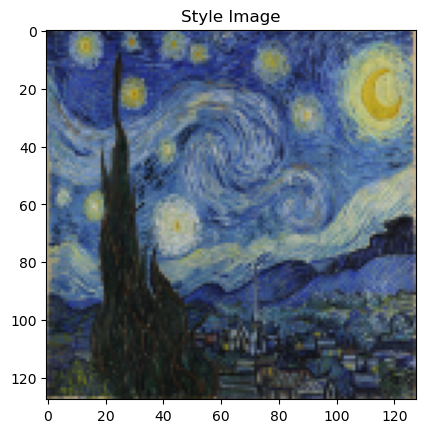

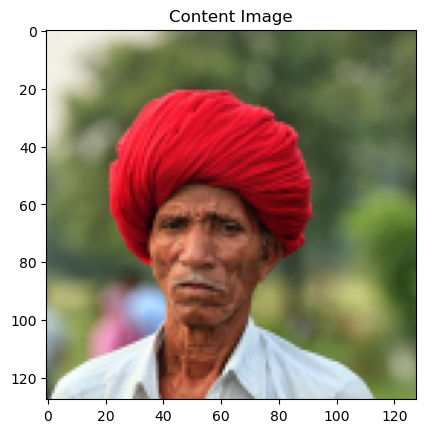

In [83]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# Evaluation Metrics (Style and Content Loss)

>We create a **content loss** class which basically measures the **MSE loss** between the input image and target image tensors.

In [84]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

> - Coming to the style loss we first calculate the gram matrix for the layers. 
>      - A gram matrix is the result of multiplying a given matrix by its transposed matrix. 
>      - This matrix is the __reshaped version of the feature maps__ of a layer. 
>      - It is a __K x N matrix__ where K is the number of feature maps in a layer L and N is the length of the feature map.


In [85]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)
    
    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

>- Now for our optimization we also need stlying in our loss function so again we create a Style loss class for this purpose.
    >- In this case, we use __Gram matrix of our target and compare to our input.__ 
    >The metric used for this pupose is again __Mean Squared Error__ as used for Content loss.

In [86]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach() #so as to not be affected by gradient update

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Model Architecture (derived from pre-trained VGG19)

>Now since we are done creating our loss functions for our input and target variable accounting for the content and stylisation, what is left is using the pretrained layers of VGG19 to our advantage.

In [87]:
cnn = models.vgg19(pretrained=True).features.eval()

>Additionally, VGG networks are trained on images with each channel normalized by __mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].__ We will use them to normalize the image before sending it into the network. (source: pytorch.org) 

In [88]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [89]:
vgg19_model = models.vgg19(pretrained=True)

# Display the layers in the VGG19 model
print("VGG19 Layers:")
for name, layer in vgg19_model.features.named_children():
    print(name, layer)

VGG19 Layers:
0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kern

#### Creating Our model along with specific layers of VGG19. 
>At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. 
>This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image. 

> In the following code snippet below we chose certain layers as representations for content and style. 
> - For Content we choose __conv_4.__ 
> - For Style we choose __conv_1,conv_2,conv_3,conv_4 and conv_5.__

In [90]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4'] #since this layer has most content based representation
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] # these layers represent the styling of the 
                                                                          # style image chosen as vgg19 pretraining helps
                                                                          # identify the internal represntation of the image.

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # iterable access to or list of content/style losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

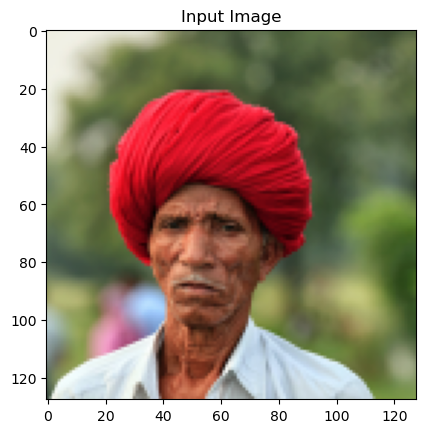

In [91]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

### Optimizer

>Defining our optimizer as given in the paper. We use __LBFGS__ as our optimizer.

In [92]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

> Now we finally create the function to run style transfer compiled with our created model optimizer and losses.

In [93]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)
    show_steps=[50, 100, 150,250]
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
                
            if run[0] in show_steps:
                visualize_output(input_img.clone(), run[0])
                
            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

def visualize_output(image, step):
    """Visualize and save the intermediate output."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = image.squeeze(0).cpu().detach().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = image * std + mean  # Undo normalization
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.title(f'Intermediate Output at Step {step}')
    plt.axis('off')
    plt.show()
#     plt.savefig(f'output_at_step_{step}.png')

# Model Architecture 

>| Layer Name        | Layer Type        | Content Loss | Style Loss |
| ----------------- | ----------------- | ------------ | ---------- |
| conv_1            | Conv2d            | No           | Yes        |
| relu_1            | ReLU (in-place)   | No           | No         |
| conv_2            | Conv2d            | No           | Yes        |
| relu_2            | ReLU (in-place)   | No           | No         |
| pool_1            | MaxPool2d         | No           | No         |
| conv_3            | Conv2d            | No           | Yes        |
| relu_3            | ReLU (in-place)   | No           | No         |
| conv_4            | Conv2d            | Yes          | Yes        |
| relu_4            | ReLU (in-place)   | No           | No         |
| pool_2            | MaxPool2d         | No           | No         |
| conv_5            | Conv2d            | No           | Yes        |
| relu_5            | ReLU (in-place)   | No           | No         |
| content_loss_4    | ContentLoss       | Yes          | No         |
| style_loss_1      | StyleLoss         | No           | Yes        |
| style_loss_2      | StyleLoss         | No           | Yes        |
| style_loss_3      | StyleLoss         | No           | Yes        |
| style_loss_4      | StyleLoss         | No           | Yes        |
| style_loss_5      | StyleLoss         | No           | Yes        |


# Evaluation

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 87.689186 Content Loss: 35.440758



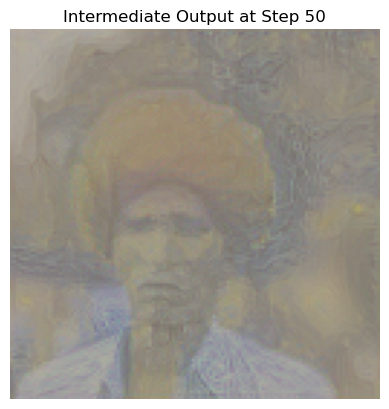

run [100]:
Style Loss : 20.034430 Content Loss: 30.935013



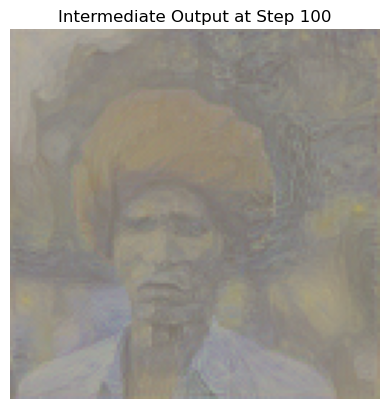

run [150]:
Style Loss : 10.699088 Content Loss: 27.915155



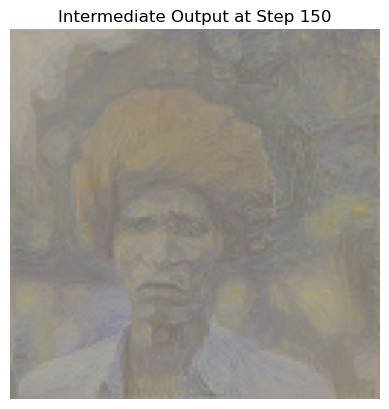

run [200]:
Style Loss : 7.404335 Content Loss: 25.866684

run [250]:
Style Loss : 5.909943 Content Loss: 24.510223



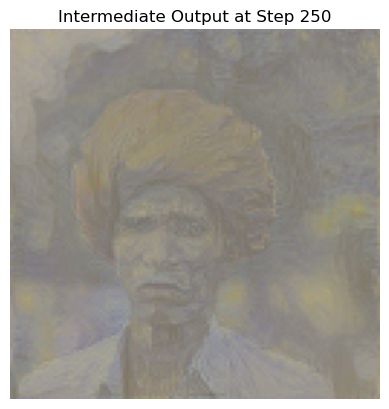

run [300]:
Style Loss : 5.032582 Content Loss: 23.658588



In [94]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

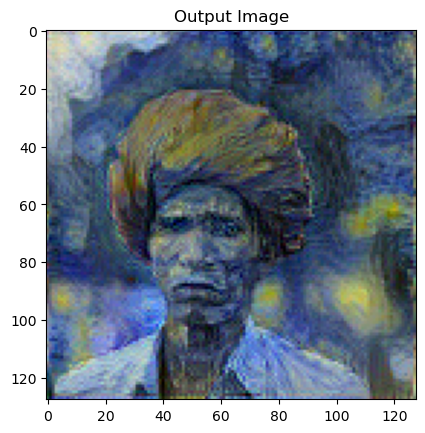

In [95]:
plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()

> As we can see the criteria for effectiveness of our model is shown by __Style Loss : 3.209781 and Content Loss: 18.767416__ which are MSE values of their respective representations.  

>Our loss to optimize is a combination of the two important factors which are 
>1) Style of Image to be transferred and 
>2) Content of image to be preserved. 

## Limitations and Potential Improvements

While our style transfer model produces visually appealing results, there are some limitations to consider:

### Limitations:

1. **Computational Cost:** Style transfer, especially on high-resolution images, can be computationally expensive and time-consuming.
  
2. **Overfitting to Style Image:** The model may overfit to the style image, making it challenging to generalize well to diverse styles.

3. **Fixed Content-Style Tradeoff:** The tradeoff between content and style is fixed during training, limiting adaptability to different artistic preferences.

### Potential Improvements:

1. **Optimization Techniques:** Explore advanced optimization techniques to speed up the style transfer process, making it more accessible for real-time applications.

2. **Adversarial Training:** Incorporate adversarial training to enhance the model's ability to generalize across various artistic styles.

3. **Dynamic Content-Style Weights:** Implement mechanisms to dynamically adjust the weights for content and style during the style transfer process, allowing for more flexible artistic control.

These points can be consiered for future enhancements, aiming to address current limitations and make the style transfer model more versatile and efficient.
